## Prediction of Revenue Per Click

### Hardware details:

We are using AWS `t2.xlarge` instance with following specs:

In [1]:
!sudo lshw -short

H/W path    Device  Class      Description
                    system     HVM domU
/0                  bus        Motherboard
/0/0                memory     96KiB BIOS
/0/401              processor  Intel(R) Xeon(R) CPU E5-2676 v3 @ 2.40GHz
/0/402              processor  CPU
/0/403              processor  CPU
/0/404              processor  CPU
/0/1000             memory     16GiB System Memory
/0/1000/0           memory     16GiB DIMM RAM
/0/100              bridge     440FX - 82441FX PMC [Natoma]
/0/100/1            bridge     82371SB PIIX3 ISA [Natoma/Triton II]
/0/100/1.1          storage    82371SB PIIX3 IDE [Natoma/Triton II]
/0/100/1.3          bridge     82371AB/EB/MB PIIX4 ACPI
/0/100/2            display    GD 5446
/0/100/3            generic    Xen Platform Device
/1          eth0    network    Ethernet interface


In [6]:
# move tables from s3 to local sql warehouse
# spark.read.csv("s3n://jakubs-bucket/", header=True, inferSchema=True)
sdf_train = spark.read.csv("s3n://jakubs-bucket/rpc/train.csv", header=True, inferSchema=True)
sdf_train.persist()
sdf_train.count()

8285423

In [7]:
spark.sql('create database rpc');
sdf_train.write.saveAsTable('rpc.train')

### Task description:

#### Advertiser programatic bidding:

 - The advertiser can set a price for each keyword/match type combination. 
 - She can even refine her price setting by taking the device (computer, mobile, ...) into account. 
 - She is furthermore free to update the prices whenever she wants. 

The set price mainly determines if her advertisement is shown to the user instead of a competitor’s one. Although the price decides on if the advertisement is shown, the advertiser only has to pay if the user clicks on the advertisement. A click redirects the user to the advertiser’s website offering him products that match what she was searching for. All the money the particular user spends in the next days on the advertiser’s website is attributed to the click, i.e. it is assumed that all the revenue the user generated with her conversions (=bookings, orders) after clicking on the advertisement was triggered by the advertisement.

#### Keyword taxonomy:

An online platform such as GetYourGuide provides easily thousands of products. Each product can have several relevant keywords such that the number of managed keywords is immense. Therefore, a hierarchy helps to categorize keywords:

 - **Keywords** belonging to the same product **are collected in an ad group**. 
 - Several ad groups can contain the same keyword, the combination of keyword and ad group is then again unique. 
 - **Ad groups** with a similar scope are bundled **in a campaign**. 
 - **Campaigns** for a common target audience are collected **in the same account**.

#### The question:

A crucial question to answer when pricing the keywords is how much revenue one can expect from a click. In other words, what is the expected Revenue per Click (RPC). Answering this question is your task in this test.

#### Evaluation metrics:

Click weighted squared distance:

$$ loss = \frac{1}{C} \sum_{i=1}^{N} \left[ c_n(r_n - \hat{r_n})^2 \right] $$

This means that we can drop all rows from dataset where number of click was zero...

### Data exploration

Tables were previously migrated from S3 bucket to the local spark metastore to speed up accessibility:

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession \
        .builder \
        .appName('Jupyter') \
        .getOrCreate()

spark.sql('show databases').show()
spark.sql('show tables in rpc').show()

+------------+
|databaseName|
+------------+
|     default|
|         rpc|
+------------+

+--------+---------+-----------+
|database|tableName|isTemporary|
+--------+---------+-----------+
|     rpc|    train|      false|
+--------+---------+-----------+



In [1]:
sdf = spark.sql("select * from rpc.train where Clicks > 0")
sdf.printSchema()
sdf.count()

root
 |-- Date: timestamp (nullable = true)
 |-- Keyword_ID: long (nullable = true)
 |-- Ad_group_ID: long (nullable = true)
 |-- Campaign_ID: long (nullable = true)
 |-- Account_ID: long (nullable = true)
 |-- Device_ID: long (nullable = true)
 |-- Match_type_ID: long (nullable = true)
 |-- Revenue: double (nullable = true)
 |-- Clicks: integer (nullable = true)
 |-- Conversions: integer (nullable = true)



8285423

### Target variable

Hypotheses:

 - we can aggregate data over time, i.e. probability of Conversion is conditionaly independent of time
 - Revenue is conidtionaly-independent from probability of conversion &#9989;
 - Revenue does not depend on time?

where conditionality is on search keywords.

 - target variable is an compound distribution where we need to model conversion at all and conditionally respective revenue
 - probably we will just use glm model for that here with possibility of extending with tensorflow and rf for revenue
 - and normal rf as a baseline
 
 
 - we need to explode here !!!

### Target variables relationship:

In [7]:
from pyspark.sql.functions import col, log, sum
tmp = sdf \
        .withColumn('log_prob_of_conv', log(col('Conversions') / col('Clicks'))) \
        .withColumn('prob_of_conv', col('Conversions') / col('Clicks')) \
        .withColumn('log_of_revenue', log(1 + col('Revenue'))) \
        .withColumn('rpc', (col('Revenue') / col('Clicks')))
        
pdf = tmp \
        .select('Clicks', 'Conversions' ,'log_prob_of_conv', 'log_of_revenue', 'rpc') \
        .sample(True, .01).toPandas()

In [8]:
pdf.corr()

,Clicks,Conversions,log_prob_of_conv,log_of_revenue,rpc
Clicks,1.000000,0.389602,-0.522079,0.177811,0.002226
Conversions,0.389602,1.000000,0.002303,0.637682,0.358066
log_prob_of_conv,-0.522079,0.002303,1.000000,-0.007176,0.435629
log_of_revenue,0.177811,0.637682,-0.007176,1.000000,0.635310
rpc,0.002226,0.358066,0.435629,0.635310,1.000000


In [14]:
pdf.describe()

,Clicks,Conversions,log_prob_of_conv,log_of_revenue,rpc
count,83147.000000,83147.000000,1640.000000,83147.000000,83147.000000
mean,3.368660,0.050934,-0.724867,0.168801,49.716454
std,5.964655,0.578765,0.987615,1.202801,600.915565
min,2.000000,0.000000,-4.677491,0.000000,0.000000
25%,2.000000,0.000000,-1.386294,0.000000,0.000000
50%,2.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,0.000000,0.000000,0.000000,0.000000
max,714.000000,85.000000,1.945910,12.367128,43297.140000


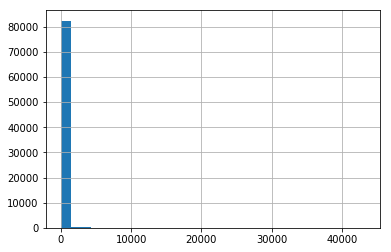

In [13]:
pdf['rpc'].hist(bins=30)

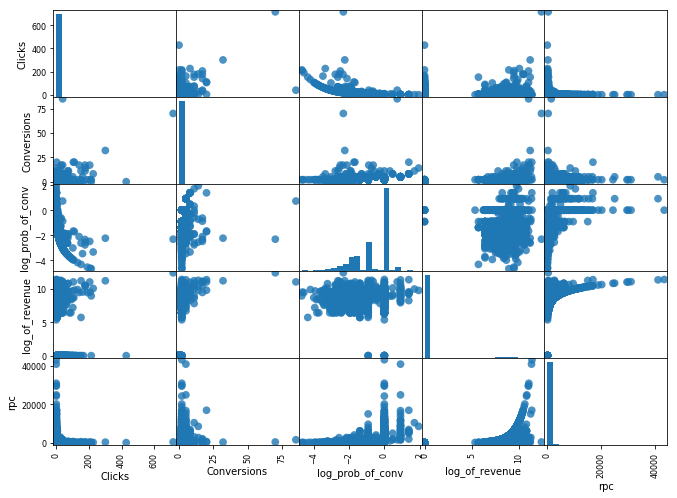

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

p = pd.plotting.scatter_matrix(pdf, figsize=(11, 8), marker='o',
                        hist_kwds={'bins': 20}, s=60, alpha=.8)

### Average probability of conversion over time

In [59]:
tmp = sdf \
        .groupBy('Date') \
        .agg(*[sum(col('Conversions')).alias('Conversions'), 
           sum(col('Clicks')).alias('Clicks'), 
           sum(col('Revenue')).alias('Revenue')]) \
        .withColumn('log_prob_of_conv', log(col('Conversions') / col('Clicks'))) \
        .withColumn('prob_of_conv', col('Conversions') / col('Clicks')) \
        .withColumn('log_of_revenue', log(1 + col('Revenue'))) \
        .withColumn('rpc', log(col('Revenue') / col('Clicks'))) \
        .orderBy(col('Date').asc()) \
        .toPandas()

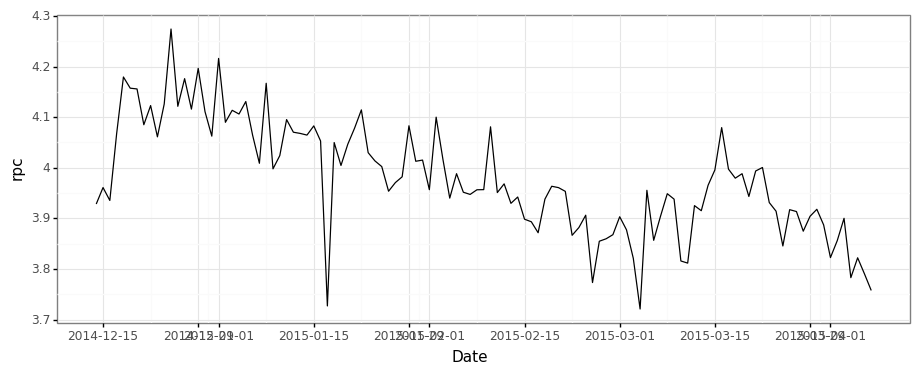

<ggplot: (-9223363275489996400)>

In [67]:
from plotnine import ggplot, geom_line, aes, theme_bw
import plotnine
plotnine.options.figure_size = (11, 4)


ggplot(aes(x='Date', y='rpc'), data=tmp) + geom_line() + theme_bw()